# Consumer Product Pricing Case Study

In this project, I develop a simple model to predict units sold for all products in a fictional Company's portfolio. 
- I begin by visualizing the data to understand its structure.
- I then proceed to engineer relevant features that might help in predicting the distribution of units sold for each product, given the product's price and product attributes.
- I plot correlations among the key variables.
- I establish criteria for evaluating a predictive model.
- I implement three different models:
    - A baseline model that predicts using the previous value of the target variable.
    - A simple linear model based only on the lag of the target variable, plus the log price.
    - A full linear model including most of the engineered features.
- I find that the full linear model performs best. I then visualize the best model's point estimates for all items across the portfolio, with a 95% empirical confidence interval.
- I discuss interpretation of the best model's fitted parameters.
- I compare the best model's estimated risk against the baseline model.
- I summarize and give suggestions for improvement.

# Import, join, and reformat data

Here we import and join the two data sets to link product information to sales data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
sales = pd.read_csv("data/sales.csv", usecols=range(1,5))
product = pd.read_csv("data/product.csv", usecols=range(1,6))

In [3]:
sales.head()

,date,product_id,price,units
0,2020-01-01,0,4.65,1126.0
1,2020-01-02,0,4.76,1205.0
2,2020-01-03,0,5.22,1007.0
3,2020-01-04,0,5.45,1282.0
4,2020-01-05,0,3.33,1037.0


In [4]:
product.head()

,brand,flavour,volume_per_joghurt_g,packsize,product_id
0,Mueller,blueberry,150,6,0
1,Oikos,chocolate,1000,1,1
2,Alnatura,strawberry,1000,1,2
3,Mueller,straciatella,500,6,3
4,Danone,straciatella,150,6,4


In [5]:
combined = sales.join(product, on="product_id", rsuffix='_prod').drop("product_id_prod",axis=1)
combined["date"] = pd.to_datetime(combined["date"])

In [6]:
combined.head()

,date,product_id,price,units,brand,flavour,volume_per_joghurt_g,packsize
0,2020-01-01,0,4.65,1126.0,Mueller,blueberry,150,6
1,2020-01-02,0,4.76,1205.0,Mueller,blueberry,150,6
2,2020-01-03,0,5.22,1007.0,Mueller,blueberry,150,6
3,2020-01-04,0,5.45,1282.0,Mueller,blueberry,150,6
4,2020-01-05,0,3.33,1037.0,Mueller,blueberry,150,6


# Product differentiation - description

Some simple descriptive charts and statistics show us that the Company has 27 unique yogurt products over 9 different brands. The largest brand, Danone, has 5 different products. The smallest, Actimel, has only one product. In general, within brands products are differentiated mostly by product flavour - blueberry, chocolate, strawberry, straciatella, or raspberry.

The majority of products have a unique combination of flavour, volume, and packsize. However, when aggregated by flavour and packsize we see that most items in the portfolio have 1 to 5 direct competitors within the portfolio. 

In [7]:
product.shape

(27, 5)

In [8]:
product["brand"].nunique()

9

In [9]:
product["flavour"].unique()

array(['blueberry', 'chocolate', 'strawberry', 'straciatella',
       'raspberry'], dtype=object)

In [10]:
product.groupby(["brand"]).count().sort_values("product_id", ascending=False)["product_id"]

brand
Danone               5
Mueller              4
Oikos                4
Rewe                 4
Alnatura             3
Activia              2
Ecke-Mit-Was-Drin    2
Ja!                  2
Actimel              1
Name: product_id, dtype: int64

In [11]:
product.groupby(["brand","flavour"]).count()["product_id"]

brand              flavour     
Actimel            blueberry       1
Activia            blueberry       1
                   straciatella    1
Alnatura           raspberry       1
                   straciatella    1
                   strawberry      1
Danone             blueberry       1
                   chocolate       1
                   straciatella    1
                   strawberry      2
Ecke-Mit-Was-Drin  raspberry       1
                   straciatella    1
Ja!                blueberry       1
                   straciatella    1
Mueller            blueberry       1
                   chocolate       1
                   straciatella    1
                   strawberry      1
Oikos              blueberry       1
                   chocolate       2
                   strawberry      1
Rewe               blueberry       1
                   chocolate       1
                   raspberry       1
                   strawberry      1
Name: product_id, dtype: int64

In [12]:
product.groupby(['flavour','packsize','volume_per_joghurt_g']).count()["product_id"]

flavour       packsize  volume_per_joghurt_g
blueberry     1         500                     1
                        1000                    1
              6         150                     1
                        500                     1
                        1000                    3
chocolate     1         500                     1
                        1000                    1
              6         150                     1
                        500                     1
                        1000                    1
raspberry     6         500                     1
                        1000                    2
straciatella  6         150                     2
                        500                     4
strawberry    1         150                     1
                        500                     1
                        1000                    1
              6         150                     1
                        1000                    2
Name:

In [13]:
product.groupby(['flavour','packsize']).count()["product_id"]

flavour       packsize
blueberry     1           2
              6           5
chocolate     1           2
              6           3
raspberry     6           3
straciatella  6           6
strawberry    1           3
              6           3
Name: product_id, dtype: int64

# Sales - description and visualization

## Type of data and number of observations

Some simple exploration shows us that we are dealing with daily observations of price and units sold between the dates January 1, 2020 and January 10, 2020. Each product has at minimum 7 observations and maximum 10 observations.

In [14]:
min(combined['date'])

Timestamp('2020-01-01 00:00:00')

In [15]:
max(combined['date'])

Timestamp('2020-01-10 00:00:00')

Text(0.5, 1.0, 'Number of observations per product')

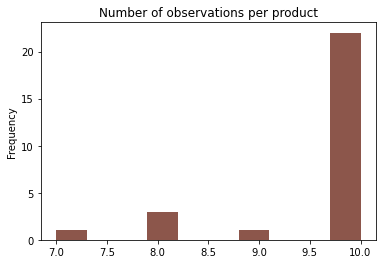

In [16]:
combined.groupby("product_id").count().plot("date", kind="hist", legend=False)
plt.title("Number of observations per product")

## Visualize sales by brand and flavour

Some simple visualizations show us that Oikos, Danone, and Mueller are the top brands in terms of total units sold (not surprising, since they have the most products). Straciatella is the most-sold flavour of yogurt.

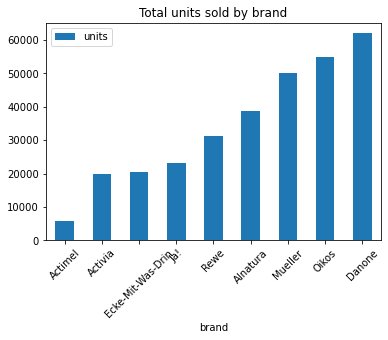

In [17]:
combined.groupby("brand").sum().reset_index().sort_values("units").plot("brand", "units", kind ="bar")
plt.title("Total units sold by brand")
plt.xticks(rotation = 45)
plt.show()

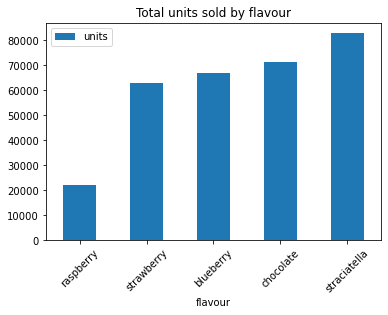

In [18]:
combined.groupby("flavour").sum().reset_index().sort_values("units").plot("flavour", "units", kind ="bar")
plt.title("Total units sold by flavour")
plt.xticks(rotation = 45)
plt.show()

## Time series visualization

In this visualization, we plot the time series of each product's units sold. Each row represents a different brand, and each column represents a flavor. Pink lines represent a packsize of 6, while blue lines represent a packsize of 1. The thickness of the lines represents the volume (grams per individual yogurt serving) of the yogurt. From the shapes of the curves, we can make a couple observations:

- Though there could be an autoregressive element to these series, the number of observations is small and thus it's difficult to tell.
- Comparing across brands' portfolio, and across different flavours, the effect of brand, yogurt volume, and packsize are not clear just from these charts.

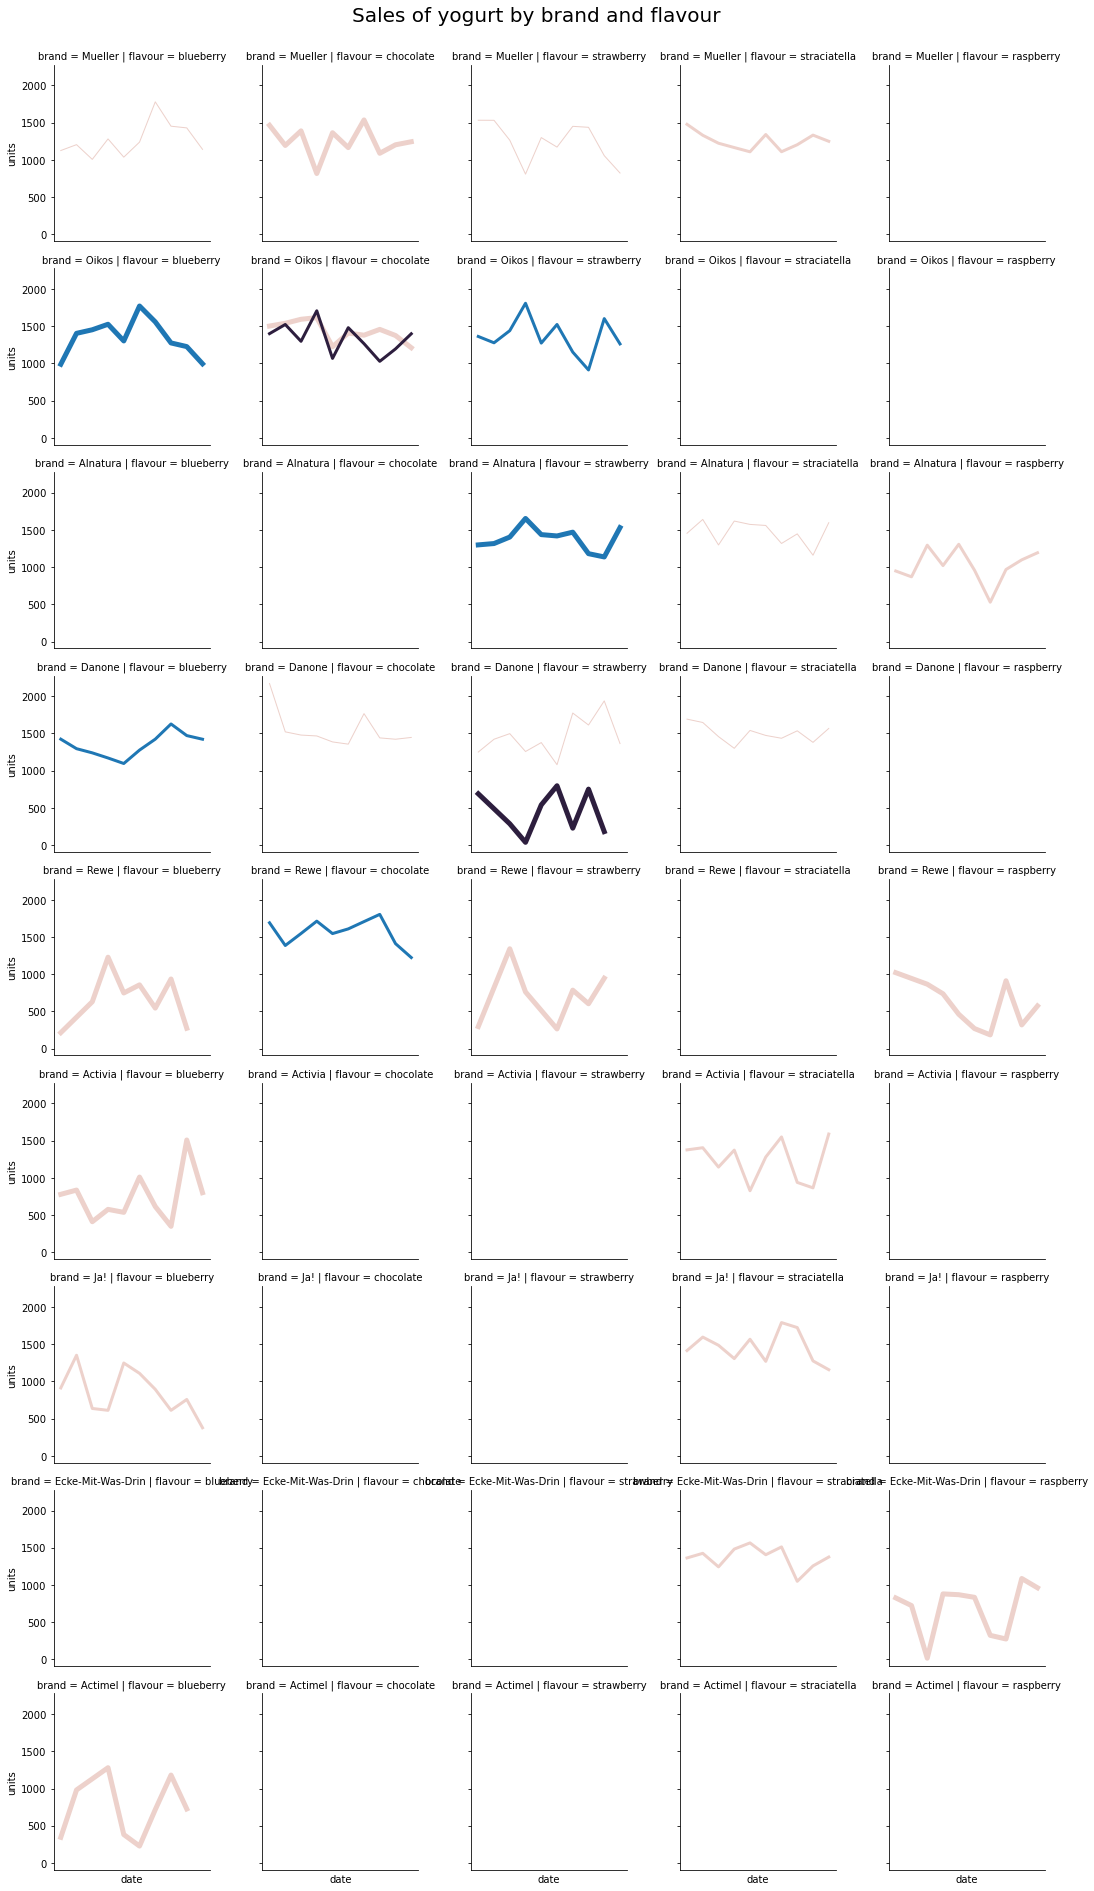

In [19]:
sizes = {150:1, 500:3, 1000:5}
g = sns.FacetGrid(combined, col="flavour",  row="brand")
g.map_dataframe(sns.lineplot, "date", "units", hue="packsize", size="volume_per_joghurt_g", sizes=sizes)
g.set(xticks=[])
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Sales of yogurt by brand and flavour', fontsize=20)
plt.show()

# Feature engineering

Beyond price, we want to use the information about product characteristics that might be useful for predicting units sold. We will build out numeric features and dummy variables and for the following characteristics:

- Log units and price, so that the coefficient can be interpreted as an elasticity
- Log price per volume, calculated as log(price/(kg per yogurt*packsize))
- Lagged target and price values (only one lag, because we have a small sample)
- Log price difference from last period, to capture a percentage increase or decrease in price from the last period
- Date of year to account for any time trend
- Brand (One-hot encoded)
- Pack size (One-hot encoded)
- Flavour (One-hot encoded)
- Volume (One-hot encoded)

Note that I will not normalize these variables when fitting models, so that the coefficients remain more interpretable.

In [20]:
combined["log_price"] = np.log(combined["price"])
combined["log_price_per_volume"] = np.log(combined["price"] / (combined["volume_per_joghurt_g"]/100*combined["packsize"]))
combined["log_units"] = np.log(combined["units"])
combined["units_lag1"] = combined.groupby("product_id")["units"].shift(1)
combined["price_lag1"] = combined.groupby("product_id")["price"].shift(1)
combined["log_units_lag1"] = combined.groupby("product_id")["log_units"].shift(1)
combined["log_price_lag1"] = combined.groupby("product_id")["log_price"].shift(1)
combined["log_price_diff"] = combined.groupby("product_id")["log_price"].diff(1)
combined['dayofyear'] = combined.date.dt.dayofyear
combined = combined.dropna()

In [21]:
cat_vars = ['brand', 'packsize', 'flavour', 'volume_per_joghurt_g']
combined_dummies = pd.get_dummies(combined, columns = cat_vars, drop_first=True)
combined_dummies[['brand', 'packsize', 'flavour', 'volume_per_joghurt_g','product_id']] = combined[['brand', 'packsize', 'flavour', 'volume_per_joghurt_g', 'product_id']]

In [22]:
combined_dummies.sort_values("date").head()

,date,product_id,price,units,log_price,log_price_per_volume,log_units,units_lag1,price_lag1,log_units_lag1,...,flavour_chocolate,flavour_raspberry,flavour_straciatella,flavour_strawberry,volume_per_joghurt_g_500,volume_per_joghurt_g_1000,brand,packsize,flavour,volume_per_joghurt_g
1,2020-01-02,0,4.76,1205.0,1.560248,-0.636977,7.094235,1126.0,4.65,7.026427,...,0,0,0,0,0,0,Mueller,6,blueberry,150
186,2020-01-02,19,7.11,981.0,1.961502,-2.132842,6.888572,345.0,9.10,5.843544,...,0,0,0,0,0,1,Actimel,6,blueberry,1000
31,2020-01-02,3,5.28,1331.0,1.663926,-1.737271,7.193686,1478.0,2.70,7.298445,...,0,0,1,0,1,0,Mueller,6,straciatella,500
176,2020-01-02,18,2.93,1405.0,1.075002,-1.227583,7.247793,990.0,4.38,6.897705,...,0,0,0,0,0,1,Oikos,1,blueberry,1000
166,2020-01-02,17,4.79,1532.0,1.566530,-0.630694,7.334329,1533.0,3.98,7.334982,...,0,0,0,1,0,0,Mueller,6,strawberry,150


# Exploring correlations

To explore the relationships between numerical variables, we create correlation matrices. We are most interested in the second row, which shows the correlation between units sold and the other variables. We note that the correlation between price and units sold is quite negative. This makes sense, implying that the higher the price, the lower the quantity sold.

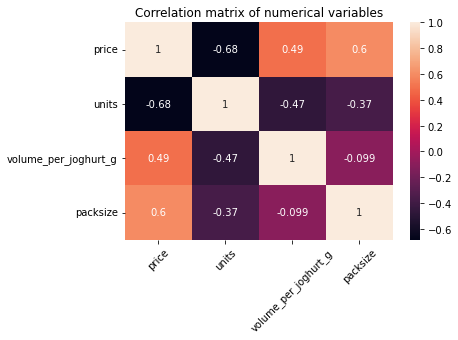

In [23]:
corr_matrix = combined_dummies[["price","units","volume_per_joghurt_g","packsize"]].corr()
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation matrix of numerical variables")
plt.xticks(rotation = 45)
plt.show()

Now we look at correlations not of the original price and unit variables, but of their logs. We do this because log differences can be viewed as percent changes, and thus the ratio of log differences can be viewed as the price elasticity of demand. The relationship between log price and log units is still quite negative.

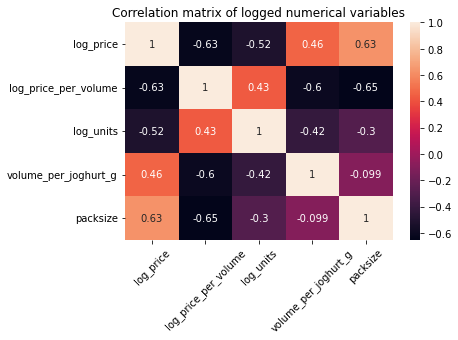

In [24]:
corr_matrix = combined_dummies[["log_price","log_price_per_volume","log_units","volume_per_joghurt_g","packsize"]].corr()
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation matrix of logged numerical variables")
plt.xticks(rotation = 45)
plt.show()

A correlation matrix of all the engineered variables suggests that while there may be associations between units sold and product features, introducing all of these variables may also create significant noise.

In [25]:
combined_dummies.columns

Index(['date', 'product_id', 'price', 'units', 'log_price',
       'log_price_per_volume', 'log_units', 'units_lag1', 'price_lag1',
       'log_units_lag1', 'log_price_lag1', 'log_price_diff', 'dayofyear',
       'brand_Activia', 'brand_Alnatura', 'brand_Danone',
       'brand_Ecke-Mit-Was-Drin', 'brand_Ja!', 'brand_Mueller', 'brand_Oikos',
       'brand_Rewe', 'packsize_6', 'flavour_chocolate', 'flavour_raspberry',
       'flavour_straciatella', 'flavour_strawberry',
       'volume_per_joghurt_g_500', 'volume_per_joghurt_g_1000', 'brand',
       'packsize', 'flavour', 'volume_per_joghurt_g'],
      dtype='object')

In [26]:
all_vars = ['log_price',
       'log_price_per_volume', 'log_units', 'units_lag1', 'price_lag1',
       'log_units_lag1', 'log_price_lag1', 'log_price_diff', 'dayofyear',
       'brand_Activia', 'brand_Alnatura', 'brand_Danone',
       'brand_Ecke-Mit-Was-Drin', 'brand_Ja!', 'brand_Mueller', 'brand_Oikos',
       'brand_Rewe', 'packsize_6', 'flavour_chocolate', 'flavour_raspberry',
       'flavour_straciatella', 'flavour_strawberry',
       'volume_per_joghurt_g_500', 'volume_per_joghurt_g_1000', 'brand',
       'packsize', 'flavour', 'volume_per_joghurt_g']

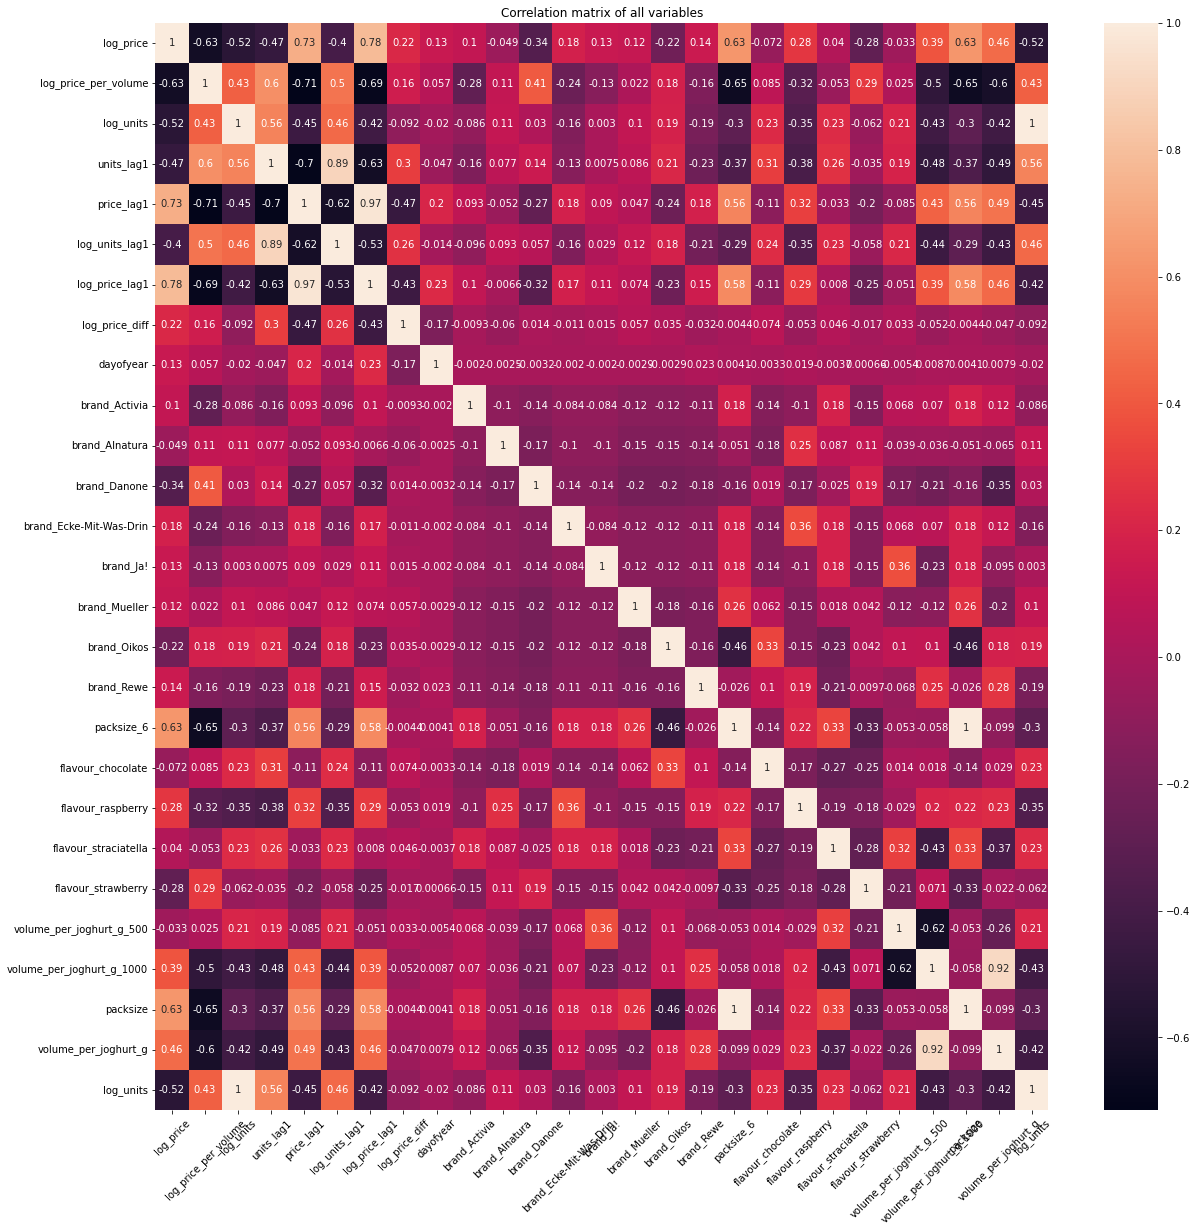

In [27]:
plt.figure(figsize=(20,20))
corr_matrix = combined_dummies[all_vars + ["log_units"]].corr()
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation matrix of all variables")
plt.xticks(rotation = 45)
plt.show()

# Evaluation metric

We will evaluate our models based on the average mean squared error (or risk) obtained through 10-fold cross-validation. Normally when performing cross-validation on time series data, we must be careful to use a time series split in order to not predict on "future" data. However, because of the small number of observations in this data (and the unequal number of observations per group), and thus the need to include most observations when training, we will assume for now that time is not a factor beyond the first lag variable, the time variable, and the log price difference variable we have included in the features.

In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state=1)

# Train-test split

We will first train our model on the observations up to January 7, 2020. We will save the out-of-sample residuals from this training in order to generate confidence intervals. Then we will generate predictions for January 8-January 10, 2020.

In [29]:
combined_test = combined_dummies.loc[combined_dummies.date >= '2020-01-08']
combined_train = combined_dummies.loc[combined_dummies.date < '2020-01-08']

## Baseline model

Our baseline model simply predicts units of product $i$ sold in period $t$ based on the units of $i$ sold in the previous period $t-1$. We assume that units sold in this period will be the same as the previous period, plus an error term.

$log(units)_{i,t} = log(units)_{i, t-1} + \epsilon_{i,t}$

In [30]:
mse_baseline = []
for train, test in kf.split(np.array(combined_train)):
    combined_train_test = pd.DataFrame(np.array(combined_train)[test], columns=combined_train.columns)
    y_pred = combined_train_test["log_units_lag1"]
    y_true = combined_train_test["log_units"]
    mse_baseline.append(mean_squared_error(y_true, y_pred))

print("Baseline MSE: " + str(round(np.mean(mse_baseline),3)))

Baseline MSE: 0.423


## Simple linear model

Now we hope to improve our baseline model by estimating a linear model with one more regressor, the log price. The coefficient on this term $\beta_2$ can be interpreted as the price elasticity of demand for the portfolio of products as a whole. Already we see an improvement in the MSE.

$log(units)_{it} = \beta_0 + \beta_1 log(units)_{i, t-1} + \beta_2 log(price)_{i,t} + \epsilon_{it}$

In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
simple_model_vars = ["log_units_lag1","log_price"]

In [33]:
lm = LinearRegression()
mse_lm = []
residuals_lm = []
for train, test in kf.split(np.array(combined_train.sort_values("date"))):
    train_full = pd.DataFrame(np.array(combined_train)[train], columns=combined_train.columns)
    test_full = pd.DataFrame(np.array(combined_train)[test], columns=combined_train.columns)
    combined_train_train = train_full[simple_model_vars]
    combined_train_test = test_full[simple_model_vars]
    y_train = train_full["log_units"]
    y_true = test_full["log_units"]
    lm.fit(combined_train_train, y_train)
    y_pred = lm.predict(combined_train_test)
    mse_lm.append(mean_squared_error(y_true, y_pred))
    residuals_lm = residuals_lm + list(y_pred - y_true)

print("Simple Linear Model MSE: " + str(round(np.mean(mse_lm),3)))

Simple Linear Model MSE: 0.296


## Full model

Now we add the rest of the engineered features into the model. We find that this model improves the MSE further, though not by a lot.

$log(units)_{it} = \beta_0 + \beta_1 log(units)_{i, t-1} +  \beta_2 log(price)_{i,t} + \sum_{j=3}^k \beta_j feature j_{i} + \epsilon_{it}$

In [34]:
full_model_vars = ['log_price',
       'log_price_per_volume', 'units_lag1', 'price_lag1',
       'log_units_lag1', 'log_price_lag1', 'log_price_diff', 'dayofyear',
       'brand_Activia', 'brand_Alnatura', 'brand_Danone',
       'brand_Ecke-Mit-Was-Drin', 'brand_Ja!', 'brand_Mueller', 'brand_Oikos',
       'brand_Rewe', 'packsize_6', 'flavour_chocolate', 'flavour_raspberry',
       'flavour_straciatella', 'flavour_strawberry',
       'volume_per_joghurt_g_500', 'volume_per_joghurt_g_1000']

In [35]:
full_lm = LinearRegression()
mse_full_lm = []
residuals_full_lm = []
for train, test in kf.split(np.array(combined_train.sort_values("date"))):
    train_full = pd.DataFrame(np.array(combined_train)[train], columns=combined_train.columns)
    test_full = pd.DataFrame(np.array(combined_train)[test], columns=combined_train.columns)
    combined_train_train = train_full[full_model_vars]
    combined_train_test = test_full[full_model_vars]
    y_train = train_full["log_units"]
    y_true = test_full["log_units"]
    full_lm.fit(combined_train_train, y_train)
    y_pred = full_lm.predict(combined_train_test)
    mse_full_lm.append(mean_squared_error(y_true, y_pred))
    residuals_full_lm  = residuals_full_lm + list(y_pred - y_true)

print("Full Linear Model MSE: " + str(round(np.mean(mse_full_lm),3)))

Full Linear Model MSE: 0.268


# Predictions

From this analysis, we conclude that the full linear model is the best fit for the data, among the models we have evaluated. We now generate predictions for the final three observed days (data that we have not trained on), with a 95% confidence interval generated from out-of-sample residuals obtained in training. The observed values are blue, fitted values are orange, and confidence bands are red.

We note that the predictions seem pretty close to the true values, though the model does fail to capture some fluctuations. In almost all cases, the observed value is within the 95% confidence bands.

In [36]:
best_lm = LinearRegression()
best_lm.fit(np.array(combined_train[full_model_vars]), combined_train["log_units"])
combined_test["y_pred"] = best_lm.predict(np.array(combined_test[full_model_vars]))
y_true = combined_test["log_units"]
ci = np.quantile(residuals_full_lm, 1 - 0.025)
combined_test["upper"] = combined_test["y_pred"] + ci
combined_test["lower"] = combined_test["y_pred"] - ci
combined_full = pd.concat([combined_train, combined_test], axis=0)

/var/folders/gd/539s1yw17y3_4zs1h2td3r_40000gn/T/ipykernel_15254/3423989165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_test["y_pred"] = best_lm.predict(np.array(combined_test[full_model_vars]))
/var/folders/gd/539s1yw17y3_4zs1h2td3r_40000gn/T/ipykernel_15254/3423989165.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_test["upper"] = combined_test["y_pred"] + ci
/var/folders/gd/539s1yw17y3_4zs1h2td3r_40000gn/T/ipykernel_15254/3423989165.py:7: SettingWithCopyWarning: 
A value is 

The observed values are blue and fitted values are orange.

Text(0.5, 0.98, 'Predicted unit sales of yogurt')

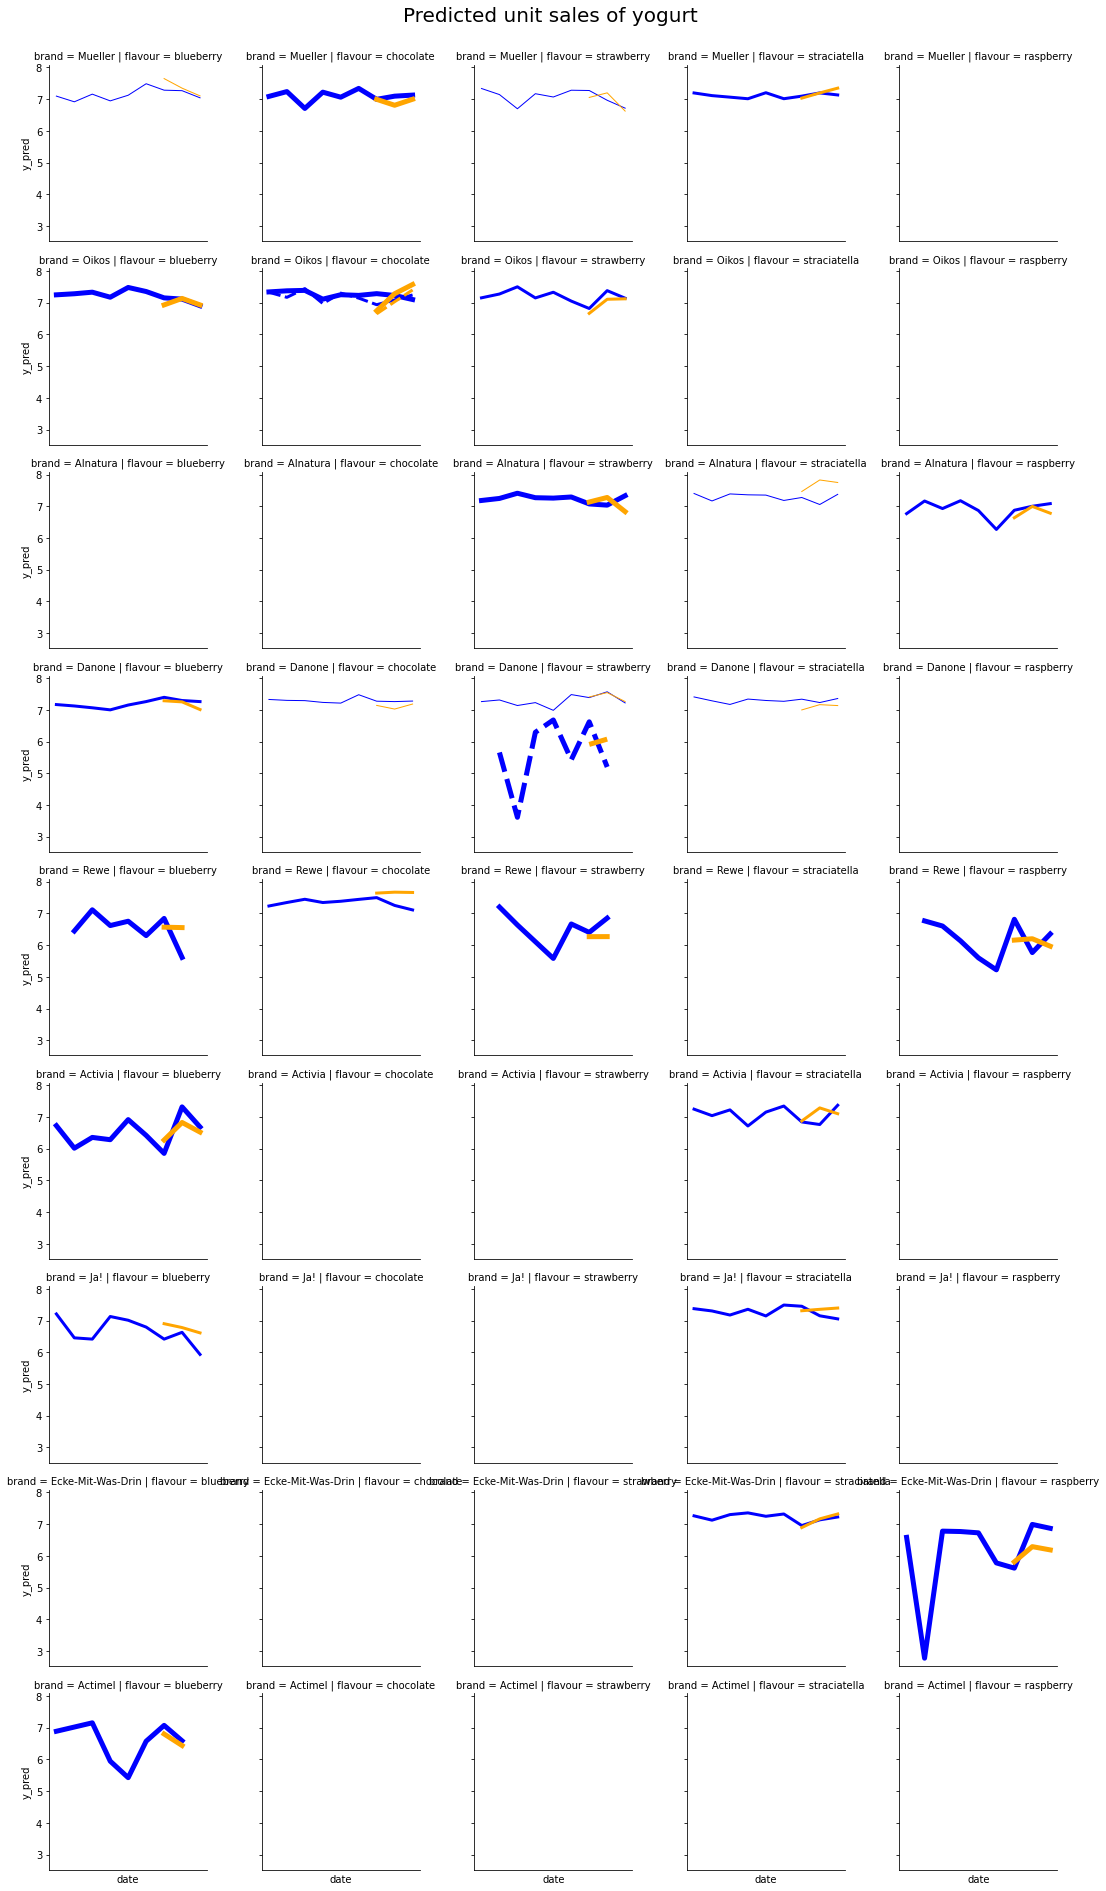

In [37]:
sizes = {150:1, 500:3, 1000:5}
g = sns.FacetGrid(combined_full, col="flavour",  row="brand")
g.map_dataframe(sns.lineplot, "date", "log_units", color="blue", size="volume_per_joghurt_g", sizes=sizes, style="packsize")
g.map_dataframe(sns.lineplot, "date", "y_pred", color="orange", size="volume_per_joghurt_g", sizes=sizes, style="packsize")
g.set(xticks=[])
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Predicted unit sales of yogurt', fontsize=20)

The observed values are blue, fitted values are orange, and confidence bands are red.

Text(0.5, 0.98, 'Predicted unit sales of yogurt with 95% confidence interval')

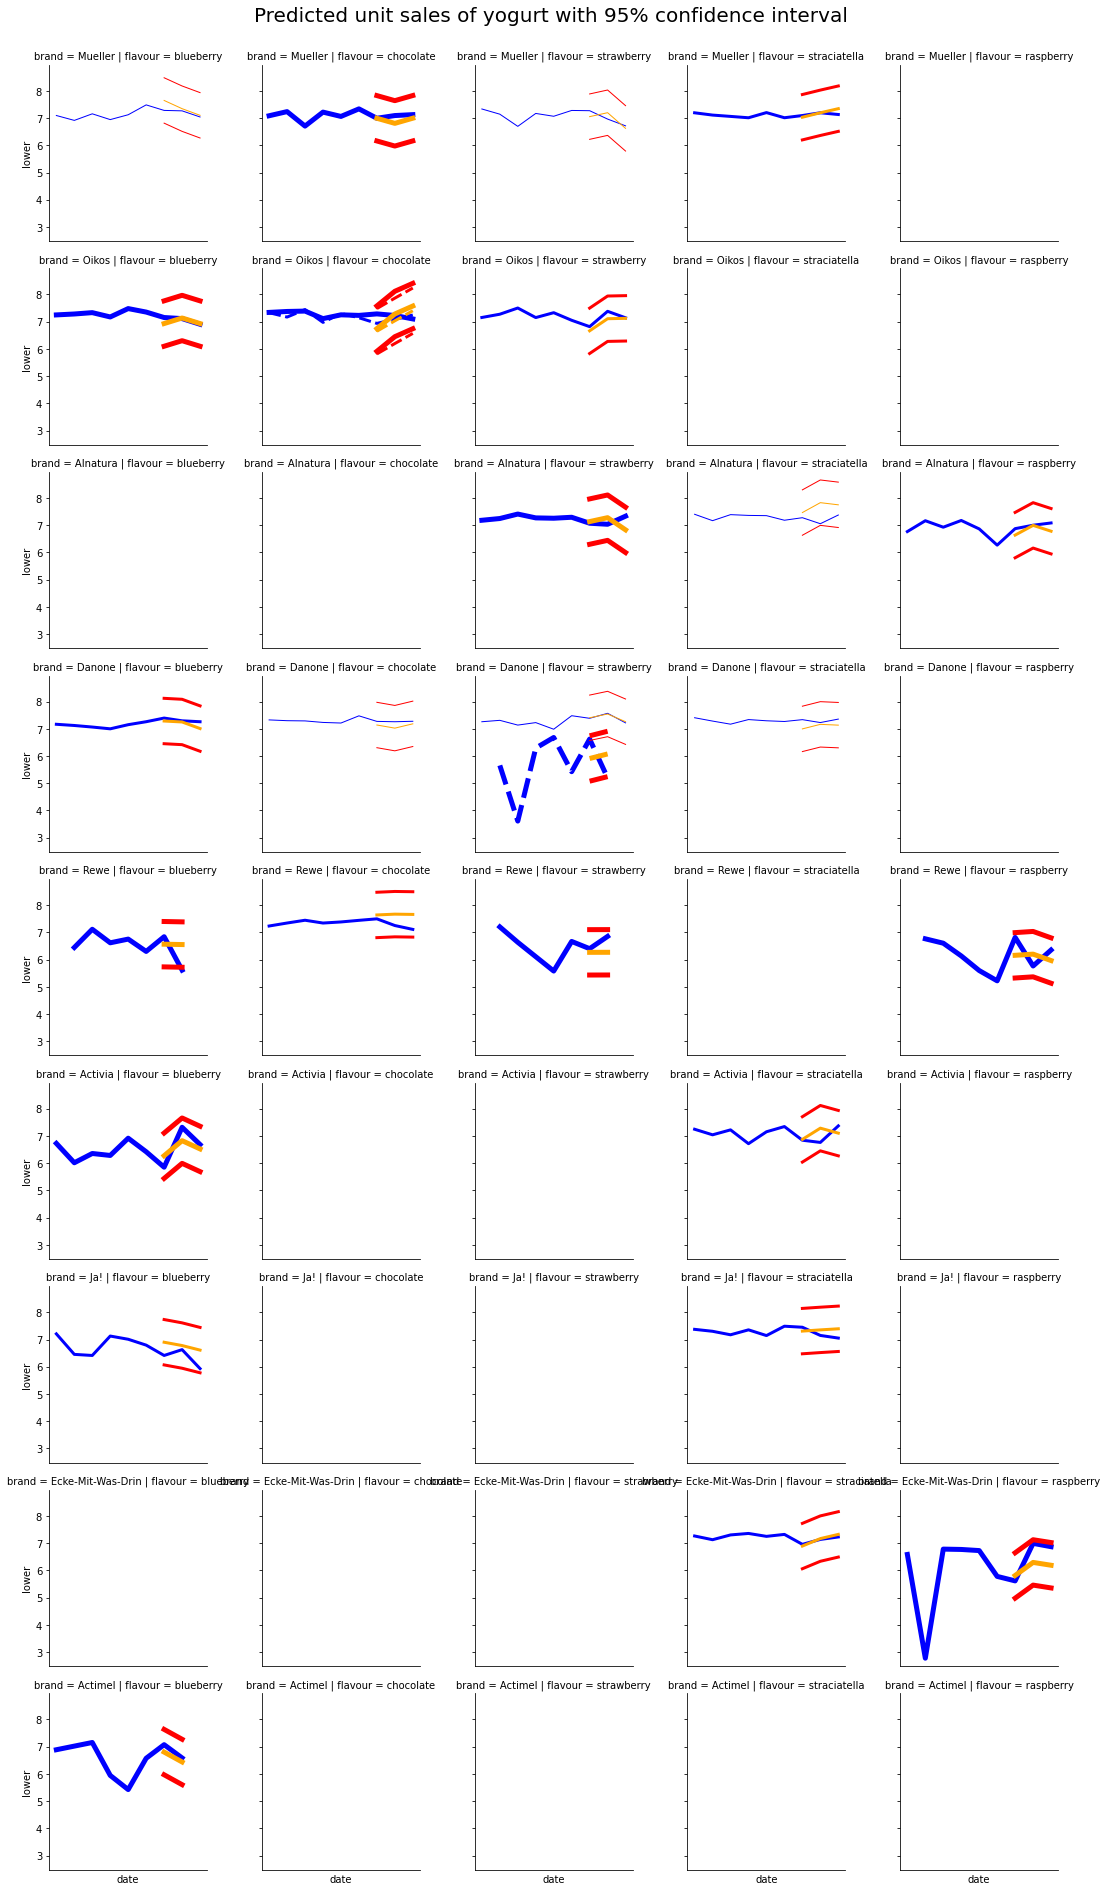

In [38]:
sizes = {150:1, 500:3, 1000:5}
g = sns.FacetGrid(combined_full, col="flavour",  row="brand")
g.map_dataframe(sns.lineplot, "date", "log_units", color="blue", size="volume_per_joghurt_g", sizes=sizes, style="packsize")
g.map_dataframe(sns.lineplot, "date", "y_pred", color="orange", size="volume_per_joghurt_g", sizes=sizes, style="packsize")
g.map_dataframe(sns.lineplot, "date", "upper", color="red", size="volume_per_joghurt_g", sizes=sizes, style="packsize")
g.map_dataframe(sns.lineplot, "date", "lower", color="red", size="volume_per_joghurt_g", sizes=sizes, style="packsize")
g.set(xticks=[])
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Predicted unit sales of yogurt with 95% confidence interval', fontsize=20)

# Parameter interpretation

The parameters estimated by our full linear model imply that across the portfolio, the average price elasticity of demand ($\beta_2$) is -0.45. This means are goods are inelastic, and if we raise the price of any good by 1%, our units sold will probably decrease around 0.45%.

The coefficient on log price per volume is near zero, meaning that consumers are more sensitive to the price of the item as a whole, not the price per volume. The coefficients on other variables are interesting in that they reveal which flavours and brands are generally more popular than others. However, we must be careful to not interpret these coefficients in a causal way, especially since this full model did not improve greatly from the simple linear model.

$log(units)_{it} = \beta_0 + \beta_1 log(units)_{i, t-1} +  \beta_2 log(price)_{i,t} + \sum_{j=3}^k \beta_j feature j_{i} + \epsilon_{it}$

In [39]:
coefs = pd.DataFrame({"Variable":full_model_vars, "Coefficient":best_lm.coef_})
coefs.sort_values("Coefficient")

,Variable,Coefficient
0,log_price,-0.454757
18,flavour_raspberry,-0.409697
6,log_price_diff,-0.401168
20,flavour_strawberry,-0.247809
4,log_units_lag1,-0.212322
22,volume_per_joghurt_g_1000,-0.165317
10,brand_Danone,-0.121744
16,packsize_6,-0.082614
5,log_price_lag1,-0.053589
1,log_price_per_volume,-0.007795


# Compare risk to baseline

By fitting the full linear model, our risk (expected MSE) improves about 49% from baseline. The performance is not much better than the simple model however, which confirms that the most important feature for predicting log units appears to be log price.

In [40]:
simple_lm = LinearRegression()
simple_lm.fit(np.array(combined_train[simple_model_vars]), combined_train["log_units"])
y_pred_simple = simple_lm.predict(np.array(combined_test[simple_model_vars]))
baseline_model_risk = mean_squared_error(combined_test["log_units"], combined_test["log_units_lag1"])
simple_model_risk = mean_squared_error(combined_test["log_units"], y_pred_simple)
best_model_risk = mean_squared_error(combined_test["log_units"], combined_test["y_pred"])
print("Estimated baseline model risk: " + str(round(baseline_model_risk,3)))
print("Estimated simple model risk: " + str(round(simple_model_risk,3)))
print("Estimated best model risk: " + str(round(best_model_risk,3)))
print("Best Model Improvement: " + str(round((baseline_model_risk - best_model_risk)/baseline_model_risk*100,2)) + "%")

Estimated baseline model risk: 0.24
Estimated simple model risk: 0.132
Estimated best model risk: 0.122
Best Model Improvement: 49.05%


# Summary & Suggestions for Improvement

In this notebook, we explored the structure of sales data for 27 different yogurt products in the Company's portfolio. We compared several different models to a baseline, and found that the best performing model (in terms of mean squared error, also referred to as the "risk" of the model) was the full linear regression model. This model decreased risk approximately 49% from baseline when tested on data that was not previously seen during training. Predictions from this model on the test set seem to generally match the observed values, with some notable deviations.

With more time, it would be worth it to explore several improvements:
- Perform more rigorous feature selection.
- With more observations, add more lags and try fitting the model to each individual product, rather than the whole data set.
- Improve time series split to make sure the model is not testing on "future" data.
- Explore tree-based models that may account for non-linearities or the importance of product features (brand, pack size) that were included in the full linear model but did not improve it.
- Explore interacting price with these product features to see if changes in price matter more for certain kinds of products.
- Engineer features that capture each product's position relative to other products in the portfolio, including competitors by flavour and packsize, as well as the average or minimum price of competitors.